# **Project 1: Implementation of a perceptron model for regression/classification**  

## Universidad de Monterrey  

### School of Engineering and Technologies  

**Virgilio Del Bosque Luna 578255 | Ingeniería en Mecatrónica**  

**Víctor Manuel Contreras González 625627 | Ingeniería en Mecatrónica**

**Marcelo Garza Rodríguez 583252| Ingeniería en Gestión Empresarial**

**Course:** Artificial Intelligence II

**Lecturer:** Dr. Andrés Hernández Gutiérrez  
**Due date:** 27 September 2024

San Pedro Garza García, Nuevo León

"Damos nuestra palabra de que hemos realizado esta actividad con integridad académica"

Bajo la premisa de que debemos entregar un modelo lo más sencillo posible cuando se trabaja con perceptrones, decidimos convertir nuestra base de datos no supervisada (sin variable target) en una supervisada. En este caso, lo que hicimos fue un modelo de K-means que nos permitió distribuir los datos de la base en 4 clases (segmentos de mercado). Posteriormente, y bajo esta misma premisa, realizamos un proceso conocido como feature importance, el cual nos da como resultado una tabla con las sumas acumuladas de la relevancia que tiene cada variable en determinado modelo (en este caso utilizamos un Random Forest Classifier). Esto nos permite entender cuáles son las variables que tienen mayor peso al momento de categorizar la información (se busca utilizar aquellas variables que expliquen al menos el 80% en acumulado), lo que nos permite ingresar al perceptrón únicamente estas variables.

# Código para selección de variables

In [15]:
# Se importa hierarchy de scipy para realizar el análisis de clustering.
import scipy.cluster.hierarchy as sch
# Se importa la librería os para manejar configuraciones del sistema operativo.
# En este caso, se configura el número de threads en 1 para optimizar el uso de recursos.
import os
os.environ["OMP_NUM_THREADS"] = '1'
# Se importa la librería pandas, que se usa para la manipulación de datos.
import pandas as pd
# Se importa matplotlib.pyplot para crear gráficos y visualizaciones de los datos.
import matplotlib.pyplot as plt
# Se importa numpy; permite realizar operaciones numéricas y trabajar con arreglos.
import numpy as np
# Se importa seaborn, una librería que facilita la creación de gráficos estadísticos atractivos.
import seaborn as sns
# Se importa AgglomerativeClustering de sklearn, una técnica de clustering que agrupa datos que se basa en las similitudes.
from sklearn.cluster import AgglomerativeClustering
# Se importa KMeans de sklearn, para dividir los datos en un número específico de clusters.
from sklearn.cluster import KMeans
# Se importa MinMaxScaler, para normalizar los datos a un rango entre 0 y 1.
# Esto mejora el rendimiento de los algoritmos de clustering.
from sklearn.preprocessing import MinMaxScaler

In [16]:
#Importamos los datos
url ='customer_segmentation_data.csv' # Especifica la URL o la ruta local del archivo CSV.
df = pd.read_csv(url) # Lee el archivo CSV y lo convierte en un DataFrame de Pandas.
print(df.shape) # Imprime las dimensiones del DataFrame, es decir, el número de filas y columnas.
df.head() # Muestra las primeras 5 filas del DataFrame para dar una vista previa de los datos.

(1000, 9)


,id,age,gender,income,spending_score,membership_years,purchase_frequency,preferred_category,last_purchase_amount
0,1,38,Female,99342,90,3,24,Groceries,113.53
1,2,21,Female,78852,60,2,42,Sports,41.93
2,3,60,Female,126573,30,2,28,Clothing,424.36
3,4,40,Other,47099,74,9,5,Home & Garden,991.93
4,5,65,Female,140621,21,3,25,Electronics,347.08


In [17]:
#convertimos variable categórica en categ numérica
# Importamos LabelEncoder para cambiar texto a números.
from sklearn.preprocessing import LabelEncoder
# Cambiamos los valores de la columna "gender" a números y guardamos el resultado en "gender_num".
df["gender_num"] = LabelEncoder().fit_transform(df["gender"])
# Cambiamos los valores de la columna "preferred_category" a números y guardamos el resultado en "preferred_category_num".
df["preferred_category_num"] = LabelEncoder().fit_transform(df["preferred_category"])
# Mostramos 5 filas al azar del DataFrame para ver cómo quedaron las nuevas columnas.
df.sample(5)

,id,age,gender,income,spending_score,membership_years,purchase_frequency,preferred_category,last_purchase_amount,gender_num,preferred_category_num
472,473,53,Female,104435,42,4,34,Home & Garden,795.81,0,3
987,988,26,Male,148451,78,5,14,Groceries,99.19,1,2
282,283,33,Male,113187,27,9,46,Electronics,886.30,1,1
220,221,62,Male,82623,51,8,37,Clothing,155.14,1,0
589,590,33,Male,93599,22,4,37,Sports,274.96,1,4


In [18]:
# Eliminamos las columnas "gender" y "preferred_category" del DataFrame.
df = df.drop(['gender', 'preferred_category'], axis=1)
# Mostramos las primeras filas del DataFrame para ver cómo quedó después de eliminar las columnas.
df.head()

,id,age,income,spending_score,membership_years,purchase_frequency,last_purchase_amount,gender_num,preferred_category_num
0,1,38,99342,90,3,24,113.53,0,2
1,2,21,78852,60,2,42,41.93,0,4
2,3,60,126573,30,2,28,424.36,0,0
3,4,40,47099,74,9,5,991.93,2,3
4,5,65,140621,21,3,25,347.08,0,1


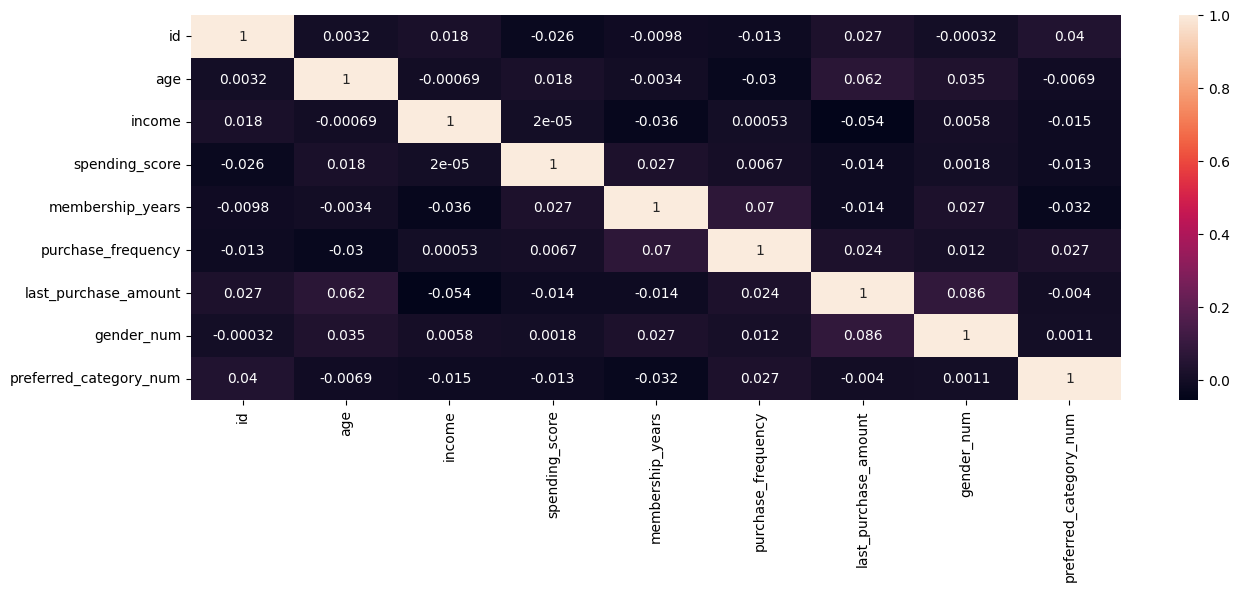

In [19]:
# Analizamos la correlación.
# Creamos una figura de 15x5.
plt.figure(figsize=(15, 5))
# Creamos un mapa de calor para mostrar la correlación entre las variables.
sns.heatmap(df.corr(), annot=True)
# Mostramos el mapa de calor.
plt.show()

En esta matriz se aprecia la correlación que tiene cada variable una con otra, de las cuales "age" y "last_purchase_amount" fueron las que resultaron tener las más altas correlaciones, ergo una mayor relevancia para el modelo.

In [20]:
#Definimos las Xs
# Seleccionamos solo las columnas 'age' y 'last_purchase_amount' porque fueron las de mayor correlación.
x1 = df[['age', 'last_purchase_amount']]
# Imprimimos 'x1'.
print(x1.shape)
# Mostramos las primeras filas de 'x1'.
x1.head()

(1000, 2)


,age,last_purchase_amount
0,38,113.53
1,21,41.93
2,60,424.36
3,40,991.93
4,65,347.08


In [21]:
# Escalamos las variables
# Creamos un objeto de escalado que normaliza los datos entre 0 y 1.
scaler = MinMaxScaler()
# Aplicamos el escalador a 'x1' y convertimos el resultado a un nuevo DataFrame llamado 'x'.
x = pd.DataFrame(scaler.fit_transform(x1))
# Mostramos las primeras filas 'x' para ver los datos ya escalados.
x.head()

,0,1
0,0.392157,0.104241
1,0.058824,0.031870
2,0.823529,0.418420
3,0.431373,0.992106
4,0.921569,0.340308


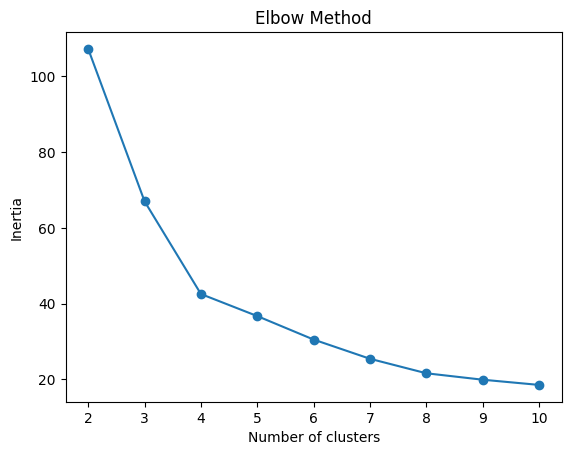

In [22]:
# Utilizamos la "gráfica del codo" para ver qué valor de K usar (Cuántos grupos hacer)
# Creamos una lista vacía para almacenar
wcss = []
# Probamos con diferentes números de clusters, desde 2 hasta 10
for i in range(2, 11):
    # Creamos el modelo KMeans con 'i' clusters
    kmeans = KMeans(n_clusters=i, random_state=0)
    # Ajustamos el modelo a los datos escalados 'x'
    kmeans.fit(x)
    # Agregamos el valor (WCSS)
    wcss.append(kmeans.inertia_)
# Graficamos el número de grupos contra la inercia para visualizar el método del codo
plt.plot(range(2, 11), wcss, marker='o')
# Se añade título y etiquetas a los ejes
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
# Mostramos la gráfica
plt.show()

El método del codo (elbow method) es uno de los métodos que se utilizan para elegir el valor óptimo de K (número de clústeres).

Básicamente, lo que se realiza en este método es iterar el modelo con diferentes valores de K y calcular la suma de las distancias cuadradas (inercia) entre los datos y su centroide asignado.

Una vez hecho esto, graficamos los resultados y, de manera visual, debemos buscar el "codo" en la tendencia, es decir, el valor de K para el cual existe el cambio más abrupto en la tendencia.


In [23]:
# Implementamos el algoritmo de clustering con K=4
# Creamos un modelo KMeans llamado 'modelo1' con 4 clusters
modelo1 = KMeans(n_clusters=4, random_state=0, n_init='auto')
# Mostramos el modelo
modelo1

KMeans(n_clusters=4, random_state=0)

In [24]:
# Obtenemos los clusters o patrones de comportamiento
# Ajustamos el modelo KMeans a los datos escalados 'x' y predecimos a qué grupo pertenece cada dato
y_cluster = modelo1.fit_predict(x)
# Mostramos las predicciones, que indican a qué grupo pertenece cada registro
y_cluster

array([1, 1, 2, 0, 2, 1, 1, 0, 3, 3, 1, 3, 1, 2, 0, 2, 2, 0, 1, 1, 0, 0,
       0, 0, 3, 1, 2, 0, 1, 0, 0, 2, 1, 2, 3, 0, 2, 3, 1, 1, 0, 2, 1, 0,
       3, 2, 2, 2, 1, 3, 2, 0, 3, 1, 3, 0, 2, 3, 3, 1, 1, 1, 3, 2, 0, 0,
       1, 2, 1, 2, 1, 3, 0, 1, 2, 3, 3, 1, 0, 3, 3, 1, 1, 2, 1, 1, 3, 1,
       0, 3, 1, 0, 2, 2, 0, 1, 3, 3, 0, 1, 1, 1, 0, 2, 0, 3, 0, 3, 2, 3,
       0, 3, 2, 1, 2, 2, 3, 3, 0, 3, 3, 2, 1, 0, 3, 1, 2, 1, 3, 3, 3, 2,
       0, 1, 0, 1, 2, 3, 1, 1, 0, 1, 3, 1, 3, 3, 3, 3, 1, 2, 2, 2, 0, 0,
       3, 0, 3, 2, 3, 1, 3, 3, 2, 3, 2, 0, 1, 1, 2, 0, 1, 0, 3, 3, 1, 0,
       2, 2, 2, 3, 2, 0, 2, 1, 1, 1, 1, 2, 3, 0, 1, 2, 2, 3, 2, 2, 0, 1,
       2, 2, 3, 0, 2, 2, 0, 0, 2, 2, 3, 2, 1, 1, 3, 0, 2, 0, 3, 2, 3, 3,
       2, 3, 3, 2, 2, 1, 3, 2, 0, 2, 1, 2, 1, 0, 1, 0, 3, 3, 3, 3, 1, 0,
       0, 3, 0, 2, 2, 1, 3, 2, 2, 0, 2, 3, 1, 2, 0, 0, 2, 0, 1, 3, 3, 3,
       3, 3, 3, 0, 1, 1, 3, 2, 3, 3, 0, 1, 3, 3, 3, 3, 3, 0, 0, 2, 2, 2,
       0, 2, 0, 0, 3, 3, 3, 3, 0, 2, 1, 1, 2, 3, 2,

In [25]:
# Incorporamos los clusters a la base de datos (Perfilar los clientes)
# Asignamos los grupos predichos (Cluster_Id) a la columna 'Cluster_Id'
df['Cluster_Id'] = y_cluster
# Mostramos las primeras filas
df.head()

,id,age,income,spending_score,membership_years,purchase_frequency,last_purchase_amount,gender_num,preferred_category_num,Cluster_Id
0,1,38,99342,90,3,24,113.53,0,2,1
1,2,21,78852,60,2,42,41.93,0,4,1
2,3,60,126573,30,2,28,424.36,0,0,2
3,4,40,47099,74,9,5,991.93,2,3,0
4,5,65,140621,21,3,25,347.08,0,1,2


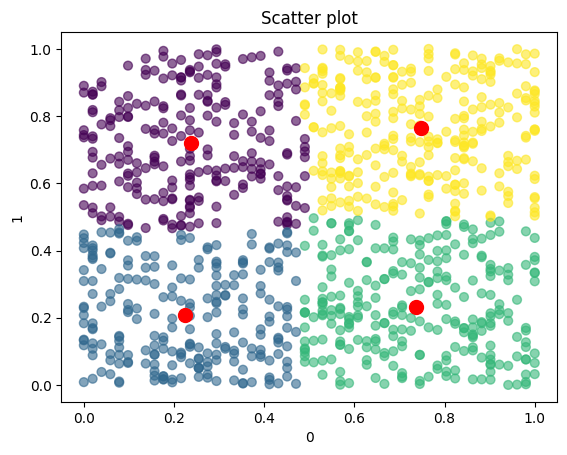

In [26]:
# Observemos los clusters encontrados en conjunto con los centroides o lideres de grupo
# Creamos un gráfico de dispersión
plt.scatter(x.iloc[:,0], x.iloc[:,1], s=40, alpha=0.6, c=y_cluster)
# Ploteamos los puntos del DataFrame 'x'
plt.scatter(modelo1.cluster_centers_[:,0], modelo1.cluster_centers_[:,1], s=100, c='red')
# Etiquetamos el eje x con el nombre de la primera columna
plt.xlabel(x.columns[0])
# Etiquetamos el eje y con el nombre de la segunda columna
plt.ylabel(x.columns[1])
# Añadimos un título
plt.title('Scatter plot')
# Mostramos el gráfico
plt.show()

El grafico anterior, nos muestra como trabajo el modelo para encontrar cada una de las clases, basicamente, los puntos son cada uno de los datos, y los 4 puntos rojos son los centroides, que son los puntos de inicio que genera el modelo para tomar como base al momento de hacer la segmentación, siendo así calcula, "todos los puntos que estene a x distancia del centroide formaran parte de x cluster".

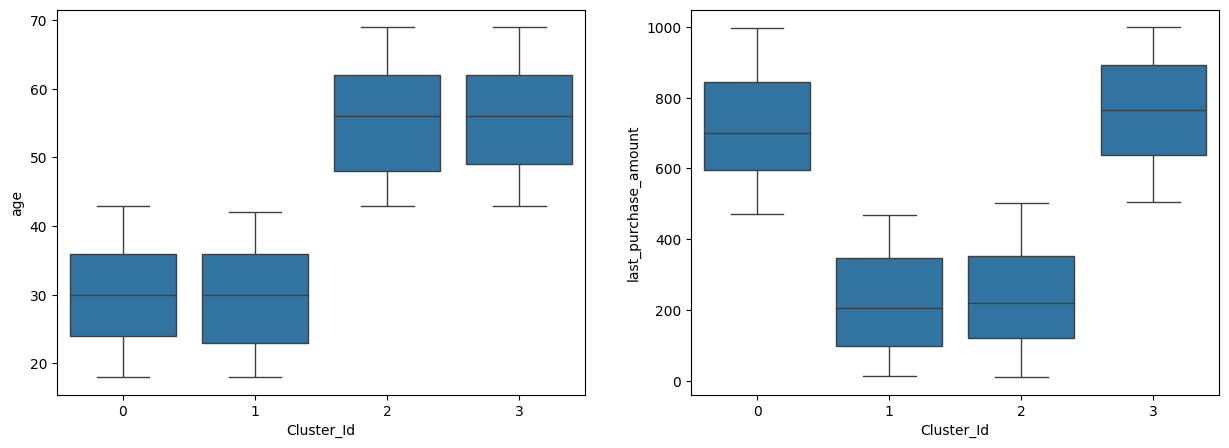

In [27]:
# Analicemos el tipo de o perfil de clientes de la tienda
# Analicemos cómo se organizan los datos de cada cluster
# Creamos una figura con dos gráficos en una fila
f, axes = plt.subplots(1, 2, figsize=(15, 5))
# Creamos un boxplot para mostrar la edad en cada cluster
sns.boxplot(x='Cluster_Id', y='age', data=df, orient='v', ax=axes[0])
# Creamos un boxplot para mostrar el monto de la última compra en cada cluster
sns.boxplot(x='Cluster_Id', y='last_purchase_amount', data=df, orient='v', ax=axes[1])
# Mostramos los gráficos
plt.show()

De los boxplots, podemos concluir lo siguiente:

Clase 0: Personas de entre 25 y 35 años, que tuvieron un último gasto cercano a los $700.

Clase 1: Personas de entre 25 y 35 años, que tuvieron un último gasto cercano a los $200.

Clase 2: Personas de entre 50 y 60 años, que tuvieron un último gasto cercano a los $700.

Clase 3: Personas de entre 50 y 60 años, que tuvieron un último gasto cercano a los $200.

In [28]:
# Guardamos el DataFrame 'df' en un archivo CSV llamado 'df_cluster.csv'
df.to_csv('df_cluster.csv', index=False)

Este nuevo archivo, con la nueva base de datos, será el que se utilizará en el proyecto en la segunda parte, la cual integrará un análisis con un perceptrón y clasificación.